ST443, Task 1: Multiclass classification on hyperspectral data
===============================================================

This script is organized into standalone sections you can run one-by-one.

It includes:
- EDA (summary stats, class balance, per-band distributions, spectra by class,
  correlations, dimensionality glimpses via PCA) with careful sampling to keep
  memory manageable on ~218k x ~221 data
- Training & evaluation of 7 required classifiers: LDA, Logistic, QDA, kNN, GBDT,
  RandomForest, SVM — with and without PCA(10)
- Metrics: accuracy, misclassification error, macro balanced accuracy, macro F1,
  macro One-vs-Rest AUC — all on a stratified holdout set
  - A compact CSV summary of results for report
  - A binary snow / ice vs all experiment (Task 1.4) using F1(positive=snow/ice)
    as the primary metric, with justification included inline
  - A mypredict() function that loads test.csv.gz and writes predictions

Data expectations (from the coursework brief):
- Features: Bands named "Band_1", ..., "Band_218" (reflectance), and p_x, p_y coordinates.
- Label: "land_type" with 8 classes.

## Section 0: Setup & Imports

This section loads all required Python packages (pandas, NumPy, scikit-learn, matplotlib, etc.), 
sets the random seed, and defines basic plotting and output-folder configuration. 

Run this cell first so that every later cell can reuse the same imports, constants, and helper settings.

In [55]:
# Section 0: Setup & Imports

# Import standard libraries for data wrangling and numerical computing
import os  # file paths and directory creation
import os
from pathlib import Path
from collections import Counter  # quick counts for sanity checks

# Core scientific stack
import numpy as np  # numerical arrays and fast math
import pandas as pd  # tabular data manipulation

# Plotting libraries
import matplotlib.pyplot as plt  # base plotting
import seaborn as sns  # statistical graphics

from IPython.display import display  # nicer DataFrame display in notebooks

# Machine learning models and tools from scikit-learn.
from sklearn.model_selection import train_test_split  # stratified holdout split
from sklearn.preprocessing import StandardScaler  # feature scaling for some models
from sklearn.decomposition import PCA  # PCA for dimensionality reduction
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix
)  # evaluation metrics
from sklearn.metrics import balanced_accuracy_score  # macro balanced accuracy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

# Model persistence to reuse the best model in mypredict()
from joblib import dump, load  # serialize models and preprocessing objects

# Additional scientific libraries
from scipy.spatial.distance import pdist, squareform  # pairwise distance computations

# Set global plotting style for consistency.
sns.set(context="notebook", style="whitegrid")  # aesthetic defaults for plots

# Create output directories if they don't exist, keeping results/ and figures/ tidy.
# Directory of currently running notebook/script
CURRENT_DIR = Path.cwd()
# Root of task_1 (one level up from scripts_notebooks)
TASK1_ROOT = CURRENT_DIR.parent

FIG_DIR = TASK1_ROOT / "figures"
RES_DIR = TASK1_ROOT / "results"
ART_DIR = TASK1_ROOT / "artifacts"

FIG_DIR.mkdir(exist_ok=True)
RES_DIR.mkdir(exist_ok=True)
ART_DIR.mkdir(exist_ok=True)

# To make your experiments reproducible, fix random seed used by numpy & sklearn
RANDOM_STATE = 10291999 

# Control how many rows we sample for heavy EDA plots to avoid OOM or sluggishness.
SAMPLE_FOR_PLOTS = 30000  # increase/decrease depending on computer capabilities

## Section 1 — LOAD THE DATA

Here we locate and read the hyperspectral dataset (`data-1.csv`) into a pandas DataFrame.
The script assumes the file lives in your `~/Downloads` folder and then optionally saves a local copy
for robustness. 

After running this section, you should have a `df` object containing all rows and columns from the coursework data.

In [56]:
# Section 1: LOAD THE DATA

# Define directory paths to look for the data file.
home_dir = os.path.expanduser("~")
downloads_path = os.path.join(home_dir, "Downloads")

# Full path to the CSV file
data_path = os.path.join(downloads_path, "data-1.csv")

# Load the data
df = pd.read_csv(data_path, low_memory=False)

# Save df locally for easy reuse in case of path issues later.
#df.to_csv("data-1_local_copy.csv", index=False)

# Print basic info to confirm shape and memory footprint right away.
print(f"Loaded data from: {data_path}")
print(f"Data shape: {df.shape[0]:,} rows x {df.shape[1]:,} columns")

Loaded data from: /Users/thomaswalton/Downloads/data-1.csv
Data shape: 215,604 rows x 223 columns


## Section 2: Basic checks & column detection

This section performs checks on the loaded data:
- Verifies that the expected label column (`land_type`) is present.
- Detects spectral band columns (those starting with `Band_`).
- Identifies spatial coordinate columns (`p_x`, `p_y`).
- Reports basic shape and class counts.

It then builds `X_full` (features) and `y_full` (labels), which are the main inputs to later EDA and modelling sections.

In [57]:
# Section 2: Basic checks & column detection

# Detect the label column. The coursework states it's 'land_type'.
label_col = "land_type"

# Define spatial columns 
spatial_cols = ["p_x", "p_y"]

# Heuristically detect band columns: names starting with 'Band ' or 'band ' then a number.
band_cols = [c for c in df.columns if c.lower().startswith("band_")]

# Safety checks: ensure we have bands and a label.
if not band_cols:
    raise KeyError("Could not detect band feature columns. Expected names like 'Band 1', 'Band 2', ...")
if label_col not in df.columns:
    raise KeyError(f"Label column '{label_col}' not found after detection.")

print(f"Detected label column: {label_col}")
print(f"Detected {len(band_cols)} band feature columns.")
if spatial_cols:
    print(f"Detected spatial feature columns: {spatial_cols}")
else:
    print("No explicit spatial columns detected (p_x, p_y). Proceeding without them.")

# For convenience, define the feature set X and target y.
feature_cols = band_cols + spatial_cols
X_full = df[feature_cols].copy()
y_full = df[label_col].astype("category").copy() # store target as categorical for clarity

# Peek at target classes and counts.
class_counts = y_full.value_counts()
print("Class distribution:")
print(class_counts.to_string())

# Ensure there are no duplicate rows with conflicting labels
dup_count = df.duplicated(subset=feature_cols, keep=False).sum()
print(f"Potential duplicate feature rows (any label): {dup_count}")
# If any exist, we would drop or resolve them

# Clean obvious numeric issues: coerce bands and spatial to numeric if strings slipped in.
X_full = X_full.apply(pd.to_numeric, errors="coerce")

# Report missingness so we know how much cleaning is necessary.
missing_by_col = X_full.isna().sum()
total_missing = int(missing_by_col.sum())
print(f"Total missing values across all features: {total_missing:,}")

Detected label column: land_type
Detected 218 band feature columns.
Detected spatial feature columns: ['p_x', 'p_y']
Class distribution:
land_type
alpine meadow            50657
alpine tundra            38900
valley floor / meadow    38424
bare rock                26314
veg-scree mix            24495
scree / sunlit rock      15153
snow / ice               11533
dark rock                10128
Potential duplicate feature rows (any label): 0
Total missing values across all features: 0


## Section 3: EDA (Exploratory Data Analysis)

This section explores the hyperspectral data to understand:
- Overall reflectance ranges and distributions
- Class balance and basic summary statistics by `land_type`
- Example per-band histograms and spectra
- Class-conditional spectral profiles and simple PCA views

The EDA is written to be memory-conscious by sampling when necessary and saving plots and tables 
to the `results/` folder for use in the written report

### EDA: what we learn about the hyperspectral data

Before fitting any models, we use EDA to understand how reflectance behaves across wavelengths
and land types, and to check for issues that could break modelling assumptions.

At a high level, the EDA shows that:

- **Class balance is uneven.** Vegetation and soil classes (e.g. *alpine meadow*, *valley floor / meadow*)
  contain many more pixels than glacier and rock surfaces. This motivates the use of macro-averaged
  metrics (macro F1, macro balanced accuracy) rather than relying only on overall accuracy.
- **Reflectance ranges are broadly comparable across bands,** with minima clustered near zero and
  maxima typically below ≈1.6, but **distributional shapes vary** from sharply right-skewed to broad
  or bimodal. This suggests that simple Gaussian assumptions with equal covariance (as in LDA)
  are unlikely to hold exactly.
- **Mean spectral signatures differ strongly by class.** Snow/ice is very bright in the early bands
  and then drops sharply at higher indices, whereas vegetation and soil classes peak in the middle 
  ranges before declining. These curved, class-specific profiles imply that separability
  arises from both overall brightness and the *shape* of each reflectance curve.
- **Bands are highly correlated in wavelength order.** Neighbouring bands carry redundant
  information, which PCA can exploit to build a compact, low-dimensional representation that still
  preserves class structure.
- **Low-dimensional PCA views preserve the main class distinctions.** In 2D and 3D PCA space,
  glacier ice forms a clearly separated cluster, while other classes occupy overlapping but structured
  regions. This explains why linear models with appropriate scaling and PCA can perform
  surprisingly well.

Taken together, the EDA suggests that:
1. Robust evaluation must account for class imbalance.
2. Models that rely on strict equal-covariance Gaussian assumptions may underperform.
3. Linear or slightly non-linear classifiers operating in a PCA-compressed space are well matched to
   the spectral patterns we observe.

In [59]:
# 3.1) Quick numeric summary of bands
desc = X_full[band_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
desc.to_csv(f"{RES_DIR}/eda_band_summary.csv", index=True)
# Show the full per-band summary in the notebook
display(desc)
print("3.1) Saved per-band summary to results/eda_band_summary.csv")

,count,mean,std,min,1%,5%,50%,95%,99%,max
Band_1,215604.0,0.095601,0.164291,-0.0120,0.0122,0.0150,0.0378,0.448000,0.893800,1.5810
Band_2,215604.0,0.094335,0.163833,-0.0126,0.0105,0.0131,0.0368,0.444885,0.889597,1.5741
Band_3,215604.0,0.095621,0.165067,-0.0119,0.0098,0.0124,0.0377,0.447400,0.896497,1.5871
Band_4,215604.0,0.099081,0.166807,-0.0088,0.0120,0.0148,0.0406,0.459200,0.903200,1.5959
Band_5,215604.0,0.100492,0.167414,-0.0093,0.0124,0.0152,0.0416,0.461785,0.906000,1.6036
...,...,...,...,...,...,...,...,...,...,...
Band_214,215604.0,0.100424,0.057765,0.0024,0.0129,0.0279,0.0896,0.200300,0.236000,0.4299
Band_215,215604.0,0.099806,0.056946,0.0041,0.0140,0.0286,0.0890,0.198400,0.233300,0.4351
Band_216,215604.0,0.095834,0.057251,0.0011,0.0109,0.0244,0.0851,0.194800,0.229400,0.4330
Band_217,215604.0,0.092850,0.054999,0.0001,0.0114,0.0245,0.0823,0.188100,0.221600,0.4291


3.1) Saved per-band summary to results/eda_band_summary.csv


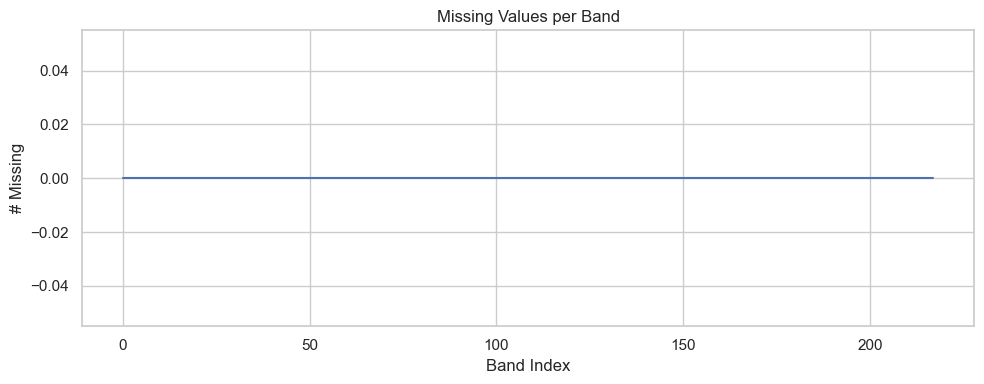

3.2) Saved missingness per band to figures/missing_per_band.png


In [60]:
# 3.2) Missingness profile plot (how many missing per band).
missing_series = X_full[band_cols].isna().sum()
plt.figure(figsize=(10, 4))
plt.plot(range(len(band_cols)), missing_series.values)
plt.title("Missing Values per Band")
plt.xlabel("Band Index")
plt.ylabel("# Missing")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/missing_per_band.png", dpi=150)
plt.show()
plt.close()
print("3.2) Saved missingness per band to figures/missing_per_band.png")

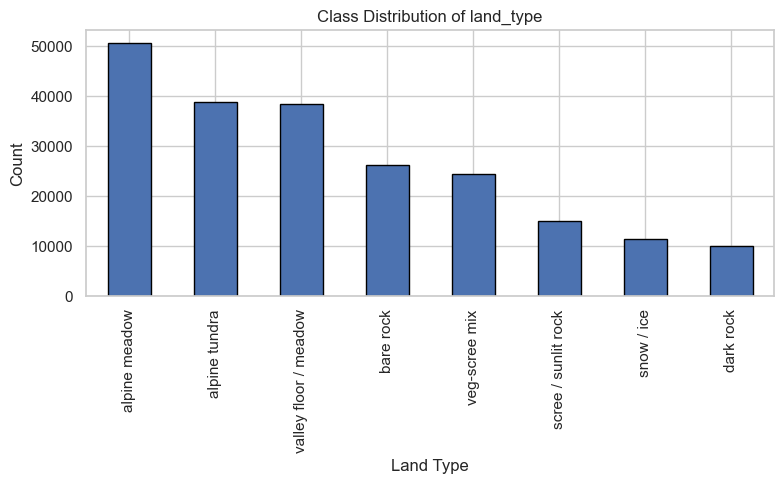

3.3) Saved class distribution plot to figures/class_distribution.png


In [61]:
# 3.3) Overall class distribution (bar chart)
plt.figure(figsize=(8, 5))
(class_counts.sort_values(ascending=False)
    .plot(kind="bar", edgecolor="black"))
plt.title("Class Distribution of land_type")
plt.xlabel("Land Type")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/class_distribution.png", dpi=150)
plt.show()
plt.close()
print("3.3) Saved class distribution plot to figures/class_distribution.png")

In [63]:
# 3.4) Per-band min/max across all pixels to check reflectance ranges
# This helps catch unit/scale problems (e.g., negative reflectance)
band_min = X_full[band_cols].min()
band_max = X_full[band_cols].max()
range_df = pd.DataFrame({"min": band_min, "max": band_max})
range_df.to_csv(f"{RES_DIR}/eda_band_ranges.csv")
print("3.3) Saved per-band min/max to results/eda_band_ranges.csv")

# Inspect the min and max across all bands
range_df.describe()
overall_min_mean = range_df['min'].mean()
overall_max_mean = range_df['max'].mean()
overall_min_std = range_df['min'].std()
overall_max_std = range_df['max'].std()

print(f"Average minimum reflectance: {overall_min_mean:.3f} + or - {overall_min_std:.3f}")
print(f"Average maximum reflectance: {overall_max_mean:.3f} + or - {overall_max_std:.3f}")

range_df.describe().to_csv(f"{RES_DIR}/eda_range_summary.csv")
# Show summary of per-band min/max ranges
display(range_df.describe())
print("3.4) Saved overall band range summary to results/eda_range_summary.csv")

3.3) Saved per-band min/max to results/eda_band_ranges.csv
Average minimum reflectance: 0.002 + or - 0.009
Average maximum reflectance: 0.958 + or - 0.444


,min,max
count,218.000000,218.000000
mean,0.001951,0.957860
std,0.008516,0.443955
min,-0.091200,0.411200
25%,-0.000300,0.531650
50%,0.003550,0.794700
75%,0.006375,1.514050
max,0.010700,1.613800


3.4) Saved overall band range summary to results/eda_range_summary.csv


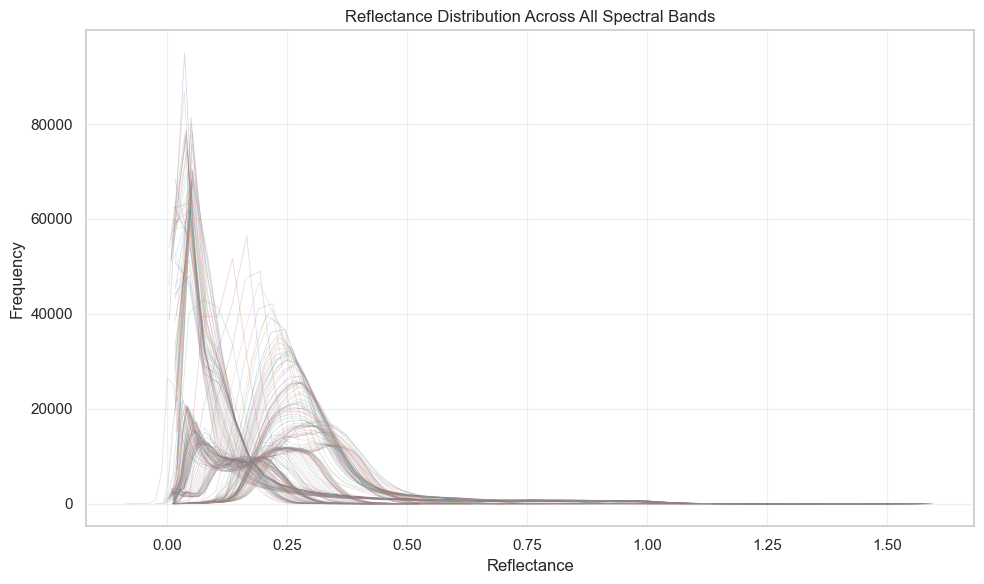

3.5) Saved all-band histogram overlay to figures/all_band_histogram_overlay.png


In [64]:
# 3.5) Histogram overlay of all spectral bands

plt.figure(figsize=(10, 6))

for band in band_cols:
    # Drop missing values just for plotting
    vals = df[band].dropna()
    
    # Compute histogram
    counts, bins = np.histogram(vals, bins=50)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot each band’s histogram curve
    plt.plot(bin_centers, counts, alpha=0.25, linewidth=0.6)

plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.title("Reflectance Distribution Across All Spectral Bands")
plt.grid(True, alpha=0.3)

# Save + show (consistent with the rest of your notebook)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/all_band_histogram_overlay.png", dpi=150)
plt.show()
plt.close()

print("3.5) Saved all-band histogram overlay to figures/all_band_histogram_overlay.png")


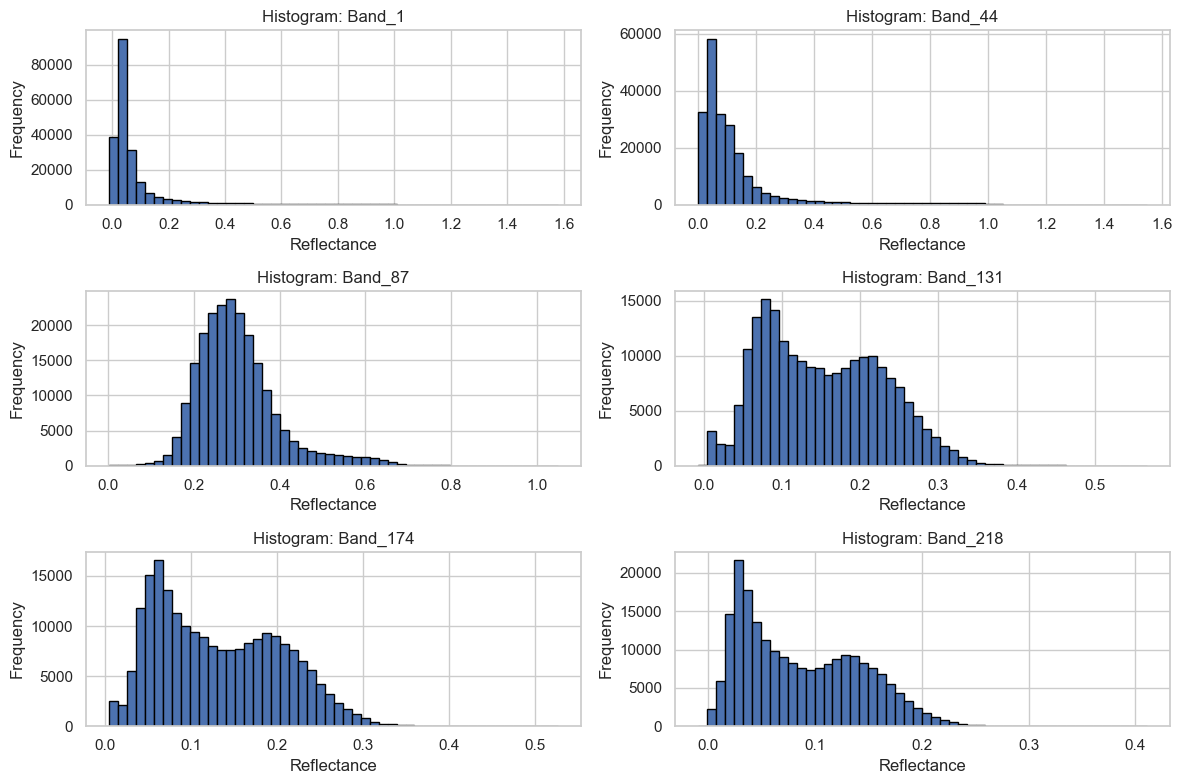

3.6) Saved example band histograms to figures/example_band_histograms.png


In [65]:
# 3.6) Plot a few representative band histograms to see shape/skew and outliers
# Choose evenly spaced bands across the spectrum to sample variability
example_band_idxs = np.linspace(0, len(band_cols) - 1, 6, dtype=int) # choosing 6 bands to show some variety in report
plt.figure(figsize=(12, 8))
for i, idx in enumerate(example_band_idxs, 1):
    plt.subplot(3, 2, i)
    col = band_cols[idx]
    # Drop NA just for plotting.
    vals = X_full[col].dropna()
    # Use a moderate bin count to see shape without too much noise.
    plt.hist(vals, bins=50, edgecolor="black")
    plt.title(f"Histogram: {col}")
    plt.xlabel("Reflectance")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/example_band_histograms.png", dpi=150)
plt.show()
plt.close()
print("3.6) Saved example band histograms to figures/example_band_histograms.png")

/var/folders/2n/pq0zg635433_jn46xk2dnysm0000gn/T/ipykernel_22542/4293229899.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(label_col)[band_cols]


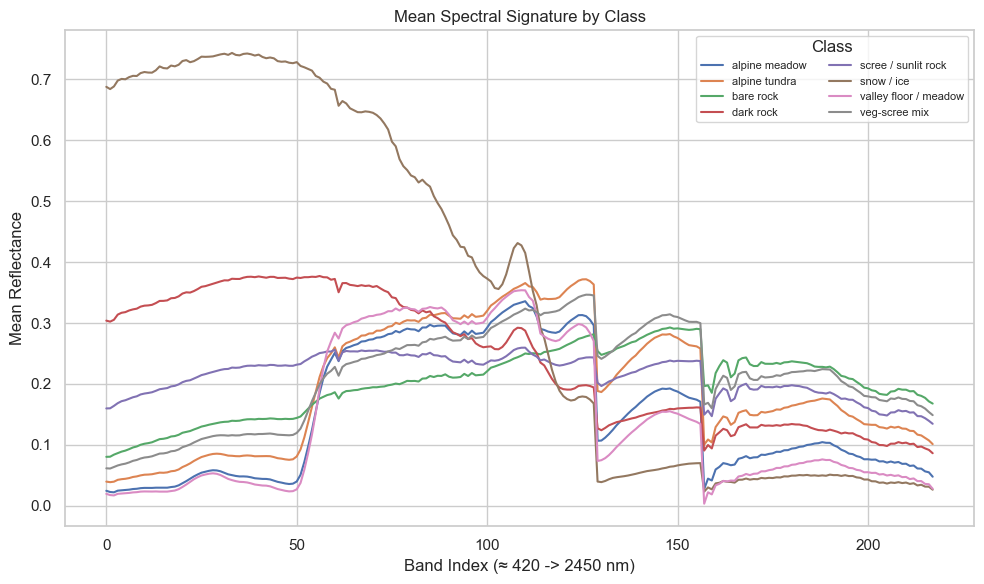

3.7) Saved mean spectral signatures plot to figures/mean_spectra_by_class.png


In [66]:
# 3.7) Mean spectral signature per class
# For each class we compute the mean reflectance for each band, then plot all class means on one figure
# Interpretation: curves separated in some wavelength regions indicate discriminative bands
mean_spectra_by_class = (
    pd.concat([X_full[band_cols], y_full], axis=1)
      .groupby(label_col)[band_cols]
      .mean()
)
plt.figure(figsize=(10, 6))
for cls in mean_spectra_by_class.index:
    plt.plot(range(len(band_cols)), mean_spectra_by_class.loc[cls].values, label=str(cls), linewidth=1.5)
plt.title("Mean Spectral Signature by Class")
plt.xlabel("Band Index (≈ 420 -> 2450 nm)")
plt.ylabel("Mean Reflectance")
plt.legend(title="Class", ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/mean_spectra_by_class.png", dpi=150)
plt.show()
plt.close()
print("3.7) Saved mean spectral signatures plot to figures/mean_spectra_by_class.png")

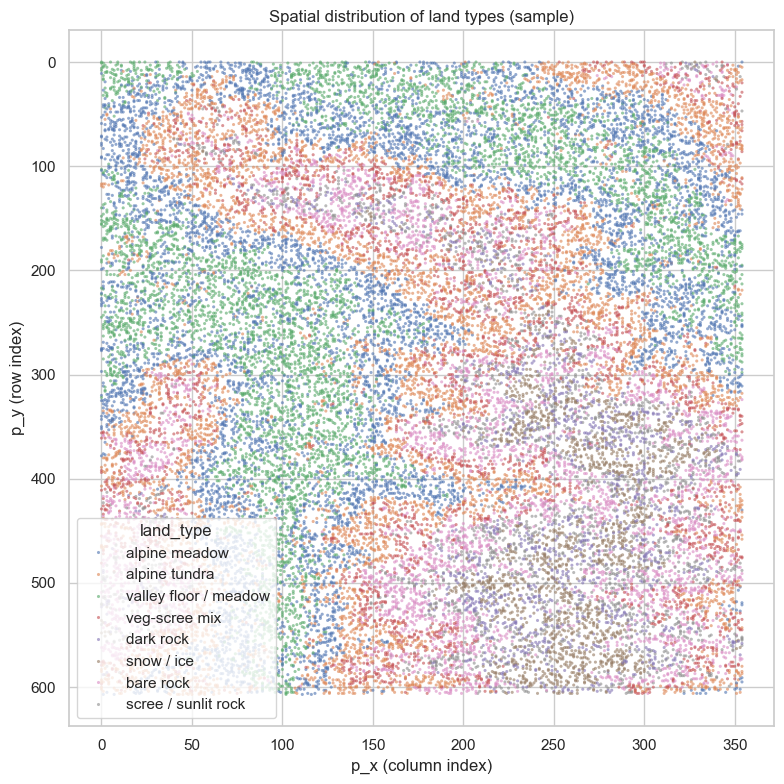

3.8) Saved spatial distribution scatter to figures/spatial_distribution_by_class.png


In [67]:
# 3.8) Spatial distribution of land types (scatter of p_x vs p_y)

# Provides intuitive sense of geographic clustering. Since some land types directly
# border each other, it makes sense that that share similar spectrac signatures at the borders

# Sample a manageable subset for plotting to avoid over-plotting
n_spatial = min(SAMPLE_FOR_PLOTS, len(df))
spatial_sample = df.sample(n=n_spatial, random_state=RANDOM_STATE)

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=spatial_sample,
    x="p_x",
    y="p_y",
    hue=label_col,
    s=5,
    alpha=0.6,
    linewidth=0,
    legend="brief"
)
plt.title("Spatial distribution of land types (sample)")
plt.xlabel("p_x (column index)")
plt.ylabel("p_y (row index)")
plt.gca().invert_yaxis()  # optional: match image-style coordinates
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/spatial_distribution_by_class.png", dpi=150)
plt.show()
plt.close()
print("3.8) Saved spatial distribution scatter to figures/spatial_distribution_by_class.png")

/var/folders/2n/pq0zg635433_jn46xk2dnysm0000gn/T/ipykernel_22542/857016929.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(label_col)[band_cols]


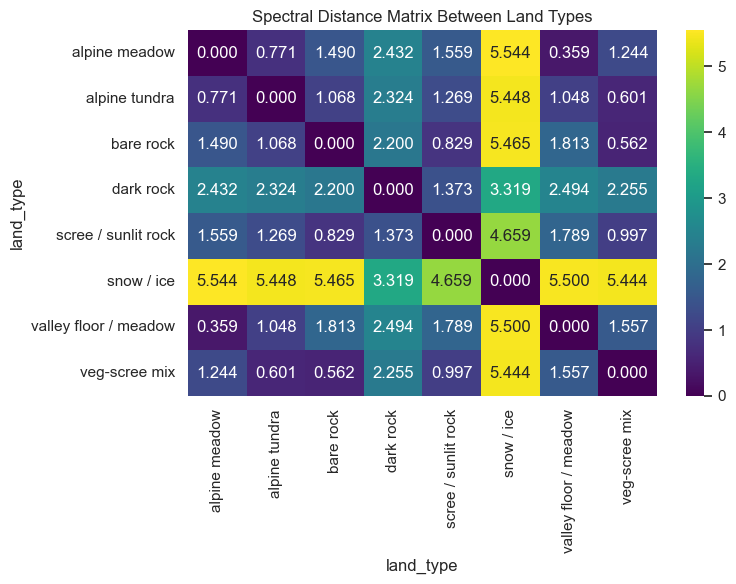

3.9) Saved spectral distance matrix to figures/spectral_distance_matrix.png


In [68]:
# 3.9) Spectral distance matrix between land types

# Compute mean reflectance per class (spectral-only)
spectral_means_by_class = (
    pd.concat([X_full[band_cols], y_full], axis=1)
      .groupby(label_col)[band_cols]
      .mean()
)

# Pairwise Euclidean distances between class-mean spectra
distances = pdist(spectral_means_by_class.values, metric="euclidean")
distance_matrix = squareform(distances)

# Convert to DataFrame for labelled heatmap
dist_df = pd.DataFrame(
    distance_matrix,
    index=spectral_means_by_class.index,
    columns=spectral_means_by_class.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    dist_df,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)

plt.title("Spectral Distance Matrix Between Land Types")
plt.tight_layout()

# Save + show (consistent with your notebook style)
plt.savefig(f"{FIG_DIR}/spectral_distance_matrix.png", dpi=150)
plt.show()
plt.close()

print("3.9) Saved spectral distance matrix to figures/spectral_distance_matrix.png")


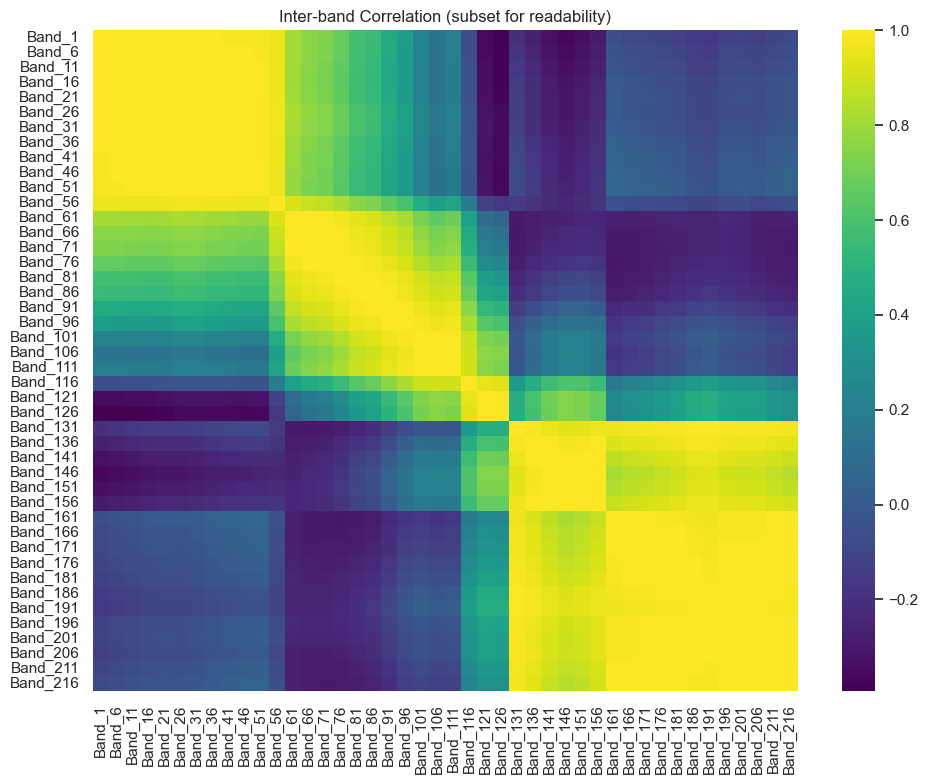

3.10) Saved band correlation snapshot to figures/band_correlation_subset.png


In [69]:
# 3.10) Correlation snapshot between bands (using a sample)
if len(X_full) > SAMPLE_FOR_PLOTS:
    sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_full), size=SAMPLE_FOR_PLOTS, replace=False)
    corr_sample = X_full.iloc[sample_idx][band_cols].corr()
else:
    corr_sample = X_full[band_cols].corr()
# Plot a small heatmap of every Nth band to keep it legible.
step = max(1, len(band_cols) // 40)  # display ~up to 40×40 tiles
subset_cols = band_cols[::step]
plt.figure(figsize=(10, 8))
sns.heatmap(corr_sample.loc[subset_cols, subset_cols], cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Inter-band Correlation (subset for readability)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/band_correlation_subset.png", dpi=150)
plt.show()
plt.close()
print("3.10) Saved band correlation snapshot to figures/band_correlation_subset.png")

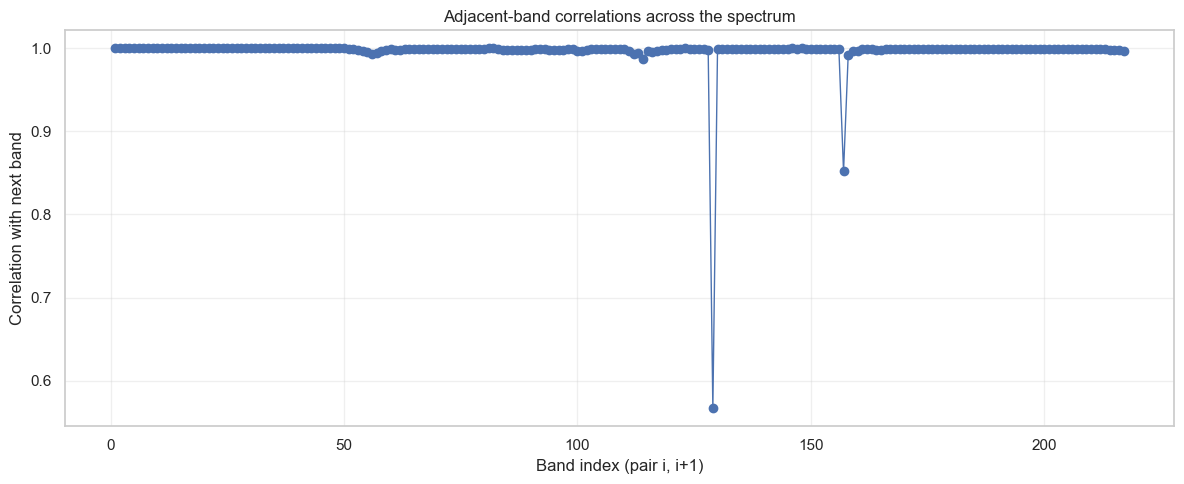

3.11) Saved adjacent-band correlation plot to figures/adjacent_band_correlations.png

Outlier band transitions (low adjacent correlations):
Pair #   Band 1       Band 2       Correlation 
--------------------------------------------------
129      Band_129     Band_130     0.5667      
157      Band_157     Band_158     0.8519      

Statistics for selected potentially problematic bands:

Band_129:
  Mean: 0.2922, Std: 0.0829
  Min: 0.0054, Max: 0.7147
  Missing values: 0

Band_157:
  Mean: 0.2082, Std: 0.0829
  Min: 0.0090, Max: 0.6430
  Missing values: 0

Band_130:
  Mean: 0.1535, Std: 0.0796
  Min: -0.0140, Max: 0.5943
  Missing values: 0

Band_158:
  Mean: 0.0841, Std: 0.0751
  Min: -0.0912, Max: 0.5162
  Missing values: 0


In [70]:
# 3.11) Adjacent-band correlations and detection of unusual band pairs

# Use only the spectral bands (exclude spatial coordinates)
spectral = X_full[band_cols]

adjacent_correlations = []
for i in range(len(band_cols) - 1):
    corr = spectral.iloc[:, i].corr(spectral.iloc[:, i + 1])
    adjacent_correlations.append(corr)

adjacent_correlations = np.array(adjacent_correlations)

plt.figure(figsize=(12, 5))
plt.plot(range(1, len(adjacent_correlations) + 1), adjacent_correlations, marker="o", linewidth=1)
plt.xlabel("Band index (pair i, i+1)")
plt.ylabel("Correlation with next band")
plt.title("Adjacent-band correlations across the spectrum")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/adjacent_band_correlations.png", dpi=150)
plt.show()
plt.close()
print("3.11) Saved adjacent-band correlation plot to figures/adjacent_band_correlations.png")

# Identify unusually low adjacent correlations (potentially problematic band transitions)
mean_corr = adjacent_correlations.mean()
std_corr = adjacent_correlations.std()
threshold = mean_corr - 2 * std_corr  # 2 standard deviations below the mean

outlier_indices = np.where(adjacent_correlations < threshold)[0]
outlier_bands = []

for idx in outlier_indices:
    band1 = band_cols[idx]
    band2 = band_cols[idx + 1]
    correlation = adjacent_correlations[idx]
    outlier_bands.append((idx + 1, band1, band2, correlation))

print("\nOutlier band transitions (low adjacent correlations):")
print(f"{'Pair #':<8} {'Band 1':<12} {'Band 2':<12} {'Correlation':<12}")
print("-" * 50)
for pair_num, b1, b2, corr in outlier_bands:
    print(f"{pair_num:<8} {b1:<12} {b2:<12} {corr:<12.4f}")

# Inspect basic stats for some problematic bands 
problem_bands = ['Band_129', 'Band_157', 'Band_130', 'Band_158']
print("\nStatistics for selected potentially problematic bands:")
for band in problem_bands:
    if band in df.columns:
        stats = df[band].describe()
        print(f"\n{band}:")
        print(f"  Mean: {stats['mean']:.4f}, Std: {stats['std']:.4f}")
        print(f"  Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")
        print(f"  Missing values: {df[band].isnull().sum()}")

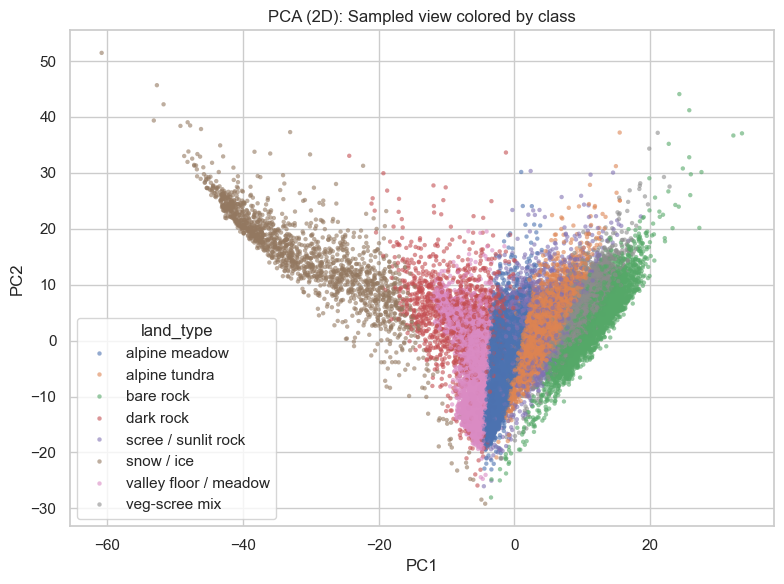

3.12) Saved PCA(2) scatter (sample) to figures/pca2_scatter_sample.png


In [71]:
# 3.12) Dimensionality glimpse: PCA on a sample, plot the first 2 principal components colored by class

# Randomly choose SAMPLE_FOR_PLOTS (30,000) distinct row indices from the full dataset
# np.random.RandomState(RANDOM_STATE) ensures reproducibility
pca_idx = np.random.RandomState(RANDOM_STATE).choice(
    len(X_full), size=SAMPLE_FOR_PLOTS, replace=False
)

# Extract the subset of feature data (only the spectral bands) and the corresponding labels
X_sample = X_full.iloc[pca_idx][band_cols].copy()
y_sample = y_full.iloc[pca_idx].copy()

# Standardize
scaler_vis = StandardScaler()
X_sample_std = scaler_vis.fit_transform(X_sample)

# Apply PCA to reduce 218 spectral bands down to 2 components
pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)

# fit_transform() both fits the PCA model (calculates the components) and transforms
# the standardized data into the new coordinate system defined by PC1 and PC2.
# The result is an array of shape (n_samples, 2) representing each observation’s
# coordinates in this new two-dimensional space.
X_pca2 = pca_vis.fit_transform(X_sample_std)

# Combine PCA results with class labels for easy plotting
pca_vis_df = pd.DataFrame({
    "PC1": X_pca2[:, 0],
    "PC2": X_pca2[:, 1],
    label_col: y_sample.values
})

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_vis_df,
    x="PC1",
    y="PC2",
    hue=label_col, # color points by land type
    s=10, # small point size for dense plots
    linewidth=0, # remove black edge outlines
    alpha=0.6 # partial transparency to visualize overlap density
)

# Add title and apply tight layout to avoid cutoff labels
plt.title("PCA (2D): Sampled view colored by class")
plt.tight_layout()

# Save the figure to the 'figures' directory for later inclusion in the report
plt.savefig(f"{FIG_DIR}/pca2_scatter_sample.png", dpi=150)
plt.show()
plt.close()

# Console log message for clarity when running the script.
print("3.12) Saved PCA(2) scatter (sample) to figures/pca2_scatter_sample.png")

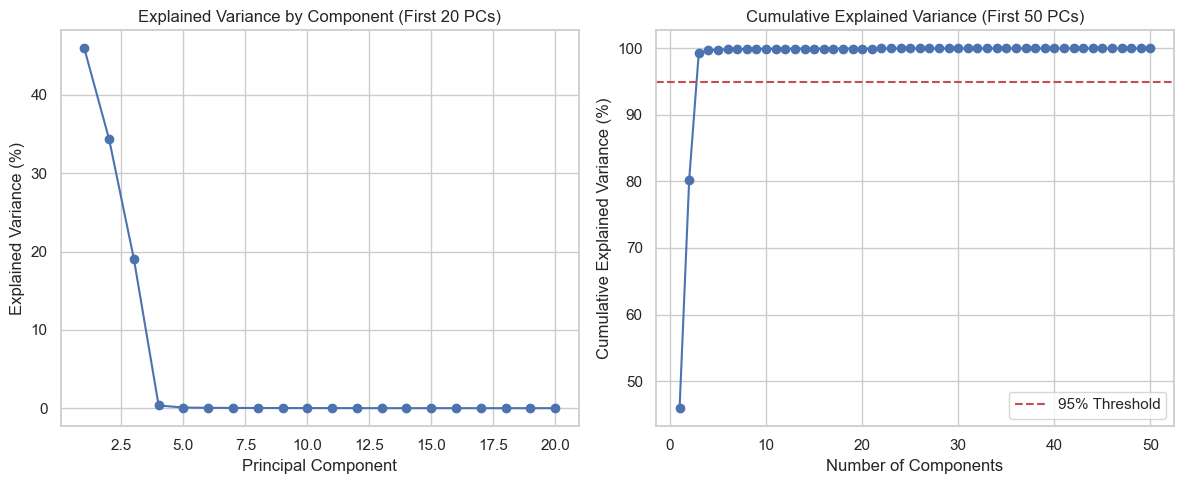

3.13) Saved PCA explained-variance curves to figures/pca_explained_variance_curves.png


In [72]:
# 3.13) PCA explained variance curves (full spectral data)

# Use spectral bands only
spectral_data = X_full[band_cols]

# Standardize before PCA (consistent with rest of notebook)
scaler_pca = StandardScaler()
spectral_std = scaler_pca.fit_transform(spectral_data)

# Fit PCA on standardized spectra
pca_full = PCA()
pca_full.fit(spectral_std)

plt.figure(figsize=(12, 5))

# Plot 1: Explained variance for first 20 PCs
plt.subplot(1, 2, 1)
plt.plot(
    range(1, 21),
    pca_full.explained_variance_ratio_[:20] * 100,
    "o-"
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance by Component (First 20 PCs)")

# Plot 2: Cumulative explained variance for first 50 PCs
plt.subplot(1, 2, 2)
cumsum = np.cumsum(pca_full.explained_variance_ratio_[:50]) * 100
plt.plot(range(1, 51), cumsum, "o-")
plt.axhline(y=95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.legend()
plt.title("Cumulative Explained Variance (First 50 PCs)")

plt.tight_layout()

# Save → Show → Close (your notebook convention)
plt.savefig(f"{FIG_DIR}/pca_explained_variance_curves.png", dpi=150)
plt.show()
plt.close()

print("3.13) Saved PCA explained-variance curves to figures/pca_explained_variance_curves.png")


In [73]:
# 3.14) Exact explained variance for the first 10 PCA components

# Extract first 10 components’ explained variance (%)
first_10_components = pca_full.explained_variance_ratio_[:10] * 100

print("Exact Explained Variance for First 10 Components:")
print("-" * 50)

for i, variance in enumerate(first_10_components, start=1):
    print(f"PC{i}: {variance:.2f}%")

cumulative_10 = first_10_components.sum()
print(f"\nCumulative sum of first 10 PCs: {cumulative_10:.2f}%")

Exact Explained Variance for First 10 Components:
--------------------------------------------------
PC1: 45.93%
PC2: 34.36%
PC3: 19.07%
PC4: 0.35%
PC5: 0.08%
PC6: 0.05%
PC7: 0.03%
PC8: 0.03%
PC9: 0.02%
PC10: 0.01%

Cumulative sum of first 10 PCs: 99.93%


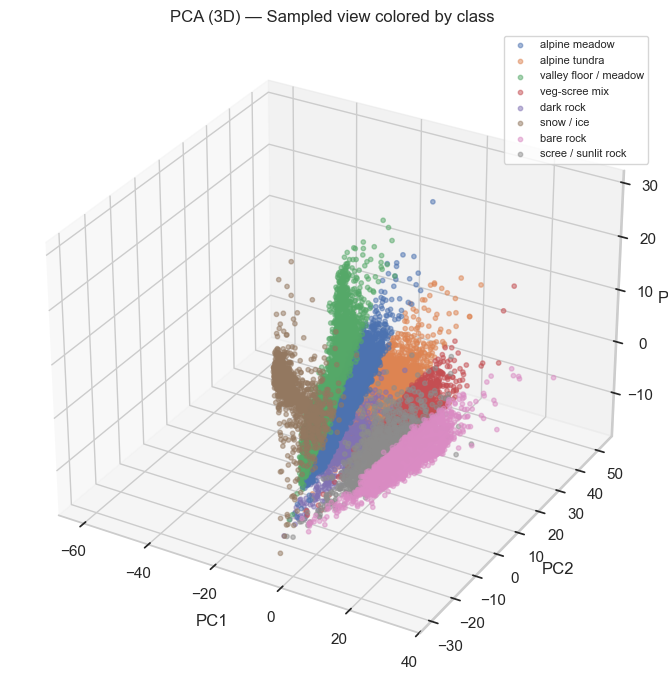

3.15) Saved PCA(3) scatter (sample) to figures/pca3_scatter_sample.png


In [74]:
# 3.15) 3D PCA visualization (PC1–PC3)

# Use the same standardized spectral data as above
pca_3d = PCA(n_components=10, random_state=RANDOM_STATE)
pca_scores = pca_3d.fit_transform(spectral_std)

# Sample for visualization
n_pca3d = min(20000, len(df))
sample_indices = np.random.RandomState(RANDOM_STATE).choice(len(df), n_pca3d, replace=False)
sample_scores = pca_scores[sample_indices]
sample_labels = y_full.iloc[sample_indices]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for cls in sample_labels.unique():
    mask = (sample_labels == cls).values
    ax.scatter(
        sample_scores[mask, 0],
        sample_scores[mask, 1],
        sample_scores[mask, 2],
        label=str(cls),
        alpha=0.5,
        s=10
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA (3D) — Sampled view colored by class")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/pca3_scatter_sample.png", dpi=150)
plt.show()
plt.close()
print("3.15) Saved PCA(3) scatter (sample) to figures/pca3_scatter_sample.png")

/var/folders/2n/pq0zg635433_jn46xk2dnysm0000gn/T/ipykernel_22542/1683837589.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(label_col)[band]
/var/folders/2n/pq0zg635433_jn46xk2dnysm0000gn/T/ipykernel_22542/1683837589.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(label_col)[band]
/var/folders/2n/pq0zg635433_jn46xk2dnysm0000gn/T/ipykernel_22542/1683837589.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence t

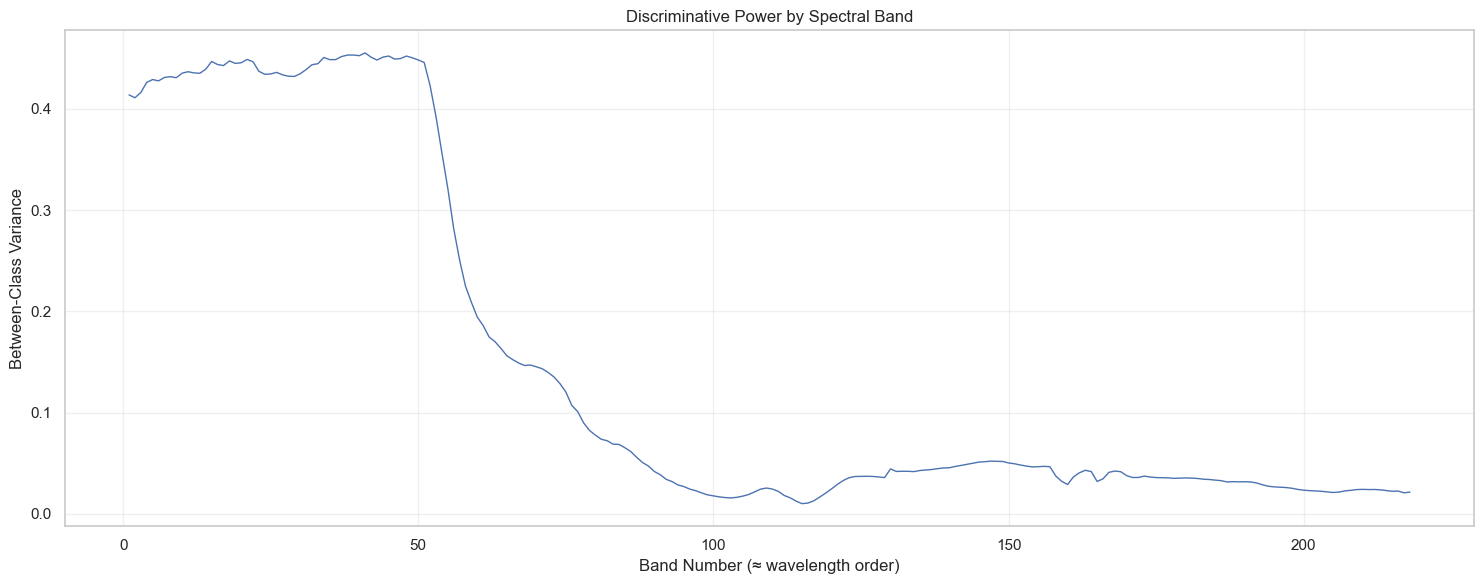

3.16) Saved between-class variance plot to figures/band_between_class_variance.png


In [75]:
# 3.16) Between-class variance for all spectral bands

# Compute between-class variance for each band
band_separability = []

# Use X_full for spectral values and y_full for labels
for band in band_cols:
    class_means = (
        pd.concat([X_full[[band]], y_full], axis=1)
          .groupby(label_col)[band]
          .mean()
    )
    overall_mean = X_full[band].mean()

    # Sum of squared deviations of class means from overall mean
    between_var = ((class_means - overall_mean) ** 2).sum()
    band_separability.append(between_var)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(band_cols) + 1), band_separability, linewidth=1)
plt.xlabel("Band Number (≈ wavelength order)")
plt.ylabel("Between-Class Variance")
plt.title("Discriminative Power by Spectral Band")
plt.grid(True, alpha=0.3)

# Save + show (consistent with your script)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/band_between_class_variance.png", dpi=150)
plt.show()
plt.close()

print("3.16) Saved between-class variance plot to figures/band_between_class_variance.png")


/var/folders/2n/pq0zg635433_jn46xk2dnysm0000gn/T/ipykernel_22542/2007927881.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(label_col)[band_cols]


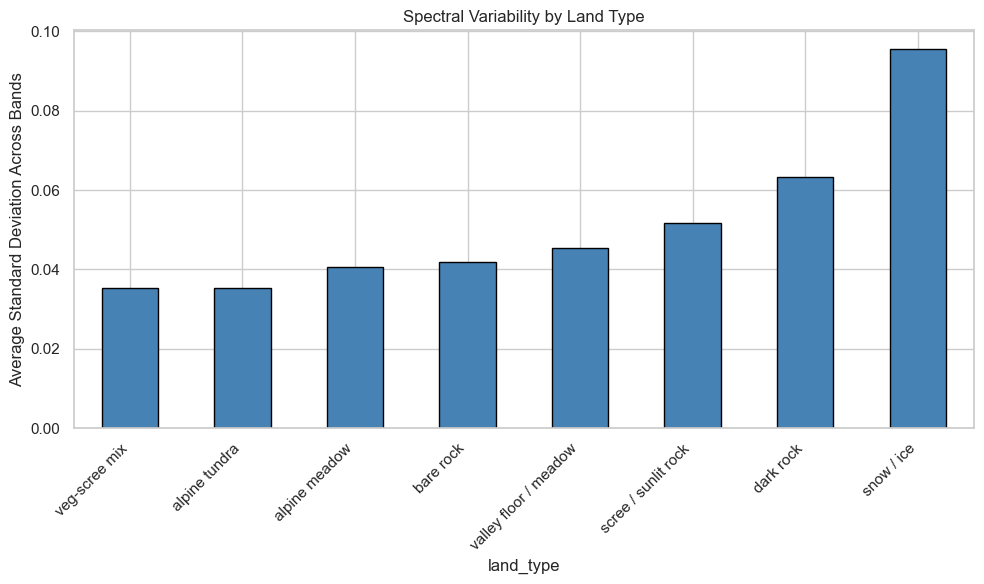

3.17) Saved spectral variability plot to figures/spectral_variability_by_class.png


In [76]:
# 3.17) Spectral variability by land type
# ----------------------------------------

# Compute per-band standard deviation for each class
spectral_stds_by_class = (
    pd.concat([X_full[band_cols], y_full], axis=1)
      .groupby(label_col)[band_cols]
      .std()
)

# Mean variability across all spectral bands for each class
class_variability = spectral_stds_by_class.mean(axis=1).sort_values()

plt.figure(figsize=(10, 6))
class_variability.plot(kind="bar", color="steelblue", edgecolor="black")

plt.title("Spectral Variability by Land Type")
plt.ylabel("Average Standard Deviation Across Bands")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/spectral_variability_by_class.png", dpi=150)
plt.show()
plt.close()

print("3.17) Saved spectral variability plot to figures/spectral_variability_by_class.png")


## Section 4: Train/Test Split & Prep

Here we construct a stratified train/validation split of the full dataset and apply preprocessing:

- Split `X_full, y_full` into `X_train, X_val, y_train, y_val` using a fixed random seed
- Set up median imputation based only on training data to avoid leakage
- Standardize features for models that benefit from scaling (e.g. Logistic Regression, SVM, kNN)
- Keep a version of the data with and without scaling so that tree-based models use the raw scale

All later modelling sections reuse these prepared train/validation sets

In [77]:
# Section 4 — TRAIN/TEST SPLIT & PREP

# We use a stratified train/validation holdout split to evaluate models fairly and simply.
X_all = X_full.copy()
y_all = y_full.copy()

# For models that need scaling, we will fit a StandardScaler on the training data and
# transform both train and validation sets. Tree-based models will use unscaled features.
# Before splitting, we will not impute; we will impute using training medians after split
# to avoid leakage.
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
)

# Identify columns to scale (bands + optional spatial)
cols_to_scale = feature_cols  # here we scale all continuous features for non-tree models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[cols_to_scale])
X_val_scaled = scaler.transform(X_val[cols_to_scale])

# For tree models, we pass the unscaled DataFrame/numpy arrays.
X_train_tree = X_train[cols_to_scale].values
X_val_tree = X_val[cols_to_scale].values

# Keep label encodings for metrics that expect numeric y; many sklearn metrics accept strings,
# but to be safe for AUC we will map classes to integers when building OVR targets.
classes = np.array(sorted(y_all.cat.categories.tolist(), key=str))
class_to_int = {c: i for i, c in enumerate(classes)}
y_train_int = y_train.map(class_to_int).values
y_val_int = y_val.map(class_to_int).values

## Section 5: Metrics helper functions

This section defines helper functions to compute and summarize evaluation metrics, including:

- Accuracy and misclassification error
- Macro balanced accuracy
- Macro F1 score
- One-vs-rest macro AUC

In [78]:
# Section 5 — METRICS: HELPERS (MULTICLASS)

def compute_all_metrics(y_true, y_pred, y_proba, class_labels):
    """
    Compute the required metrics:
      - Accuracy
      - Misclassification error
      - Macro Balanced Accuracy (OVR)
      - Macro F1
      - Macro AUC (OVR)
      - Confusion matrix (returned as a numpy array)

    y_true: array-like of true class labels (original labels, not ints)
    y_pred: array-like of predicted class labels (original labels)
    y_proba: array of shape (n_samples, n_classes) with probability estimates.
             Some models (e.g., SVM with probability=True) provide this.
    class_labels: array of class labels in the same order as y_proba columns.
    """
    # Accuracy is the simplest "overall correctness" metric.
    acc = accuracy_score(y_true, y_pred)
    # Misclassification error is just 1 - accuracy.
    miscls = 1.0 - acc
    # Macro F1 is the unweighted mean of per-class F1s; it balances across classes.
    f1_macro = f1_score(y_true, y_pred, average="macro")
    # Macro balanced accuracy averages TPR and TNR per class (via balanced_accuracy_score).
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    # Macro AUC: One-vs-Rest AUC per class averaged. Requires probability scores.
    # We compute for each class k, using y_true==k vs rest and the predicted proba for class k.
    aucs = []
    # Convert y_true to a numpy array to compare with class labels.
    y_true_np = np.array(y_true)
    for i, k in enumerate(class_labels):
        # Binary ground truth for class k vs rest.
        y_bin = (y_true_np == k).astype(int)
        # Use predicted probability for class k (column i).
        try:
            auc_k = roc_auc_score(y_bin, y_proba[:, i])
            aucs.append(auc_k)
        except ValueError:
            # If a class is missing in y_true of the validation fold, AUC is undefined;
            # skip it from the average (rare with large data).
            pass
    auc_macro = float(np.mean(aucs)) if aucs else np.nan

    # Confusion matrix for detailed error analysis (rows=true, cols=pred).
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    return {
        "Accuracy": acc,
        "Misclass Error": miscls,
        "Avg Balanced Acc": bal_acc,
        "F1 (macro)": f1_macro,
        "AUC (macro)": auc_macro,
        "Confusion Matrix": cm,
    }


## Section 6: Raw Models (no PCA), Train & Eval

In this section we fit and evaluate all required classifiers on the original (non-PCA) feature space:

- LDA
- Multinomial Logistic Regression (with L2 regularisation)
- QDA
- k-NN
- Gradient Boosted Trees
- Random Forest
- SVM (RBF kernel)

Each model is trained on the training set, evaluated on the validation set, 
and its metrics are stored in a shared results structure for later comparison.

In [ ]:
# Section 6: Raw Models (no PCA) Training & Evaluation

# We define a simple training function per model to keep the main flow readable.
# For clarity, models that benefit from scaling use (X_train_scaled, X_val_scaled).
# Tree-based models use (X_train_tree, X_val_tree).

results = []  # we will append a dict per model and then make a summary CSV

def eval_and_log(model_name, y_pred, proba, class_labels, tag="raw"):
    """
    Compute metrics and log into results[] along with metadata.
    'tag' differentiates raw features vs PCA(10) variants in the summary table.
    """
    metrics = compute_all_metrics(y_val, y_pred, proba, class_labels)
    row = {
        "Model": model_name,
        "Variant": tag,
        "Accuracy": metrics["Accuracy"],
        "Misclass Error": metrics["Misclass Error"],
        "Avg Balanced Acc": metrics["Avg Balanced Acc"],
        "F1 (macro)": metrics["F1 (macro)"],
        "AUC (macro)": metrics["AUC (macro)"],
    }
    results.append(row)
    # Also save the confusion matrix to a per-model CSV for inspection in the report.
    cm = metrics["Confusion Matrix"]
    cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in classes], columns=[f"pred_{c}" for c in classes])
    cm_path = f"{RES_DIR}/confmat__{model_name.replace(' ', '_')}__{tag}.csv"
    cm_df.to_csv(cm_path)
    print(f"{model_name} ({tag}) — Acc={row['Accuracy']:.4f} | BalAcc={row['Avg Balanced Acc']:.4f} | F1={row['F1 (macro)']:.4f} | AUC={row['AUC (macro)']:.4f}")
    print(f"Saved confusion matrix to {cm_path}")

# 6.1 — LDA (with shrinkage to stabilize covariances; avoids singularity warnings).
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")  # shrinkage auto-chooses a regularization
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_val_scaled)
proba_lda = lda.predict_proba(X_val_scaled)
eval_and_log("LDA", y_pred_lda, proba_lda, classes, tag="raw")

# 6.2 — Multinomial Logistic Regression (strong baseline for multiclass).
logreg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,
    C=1.0,
    n_jobs=None,
    random_state=RANDOM_STATE
)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_val_scaled)
proba_log = logreg.predict_proba(X_val_scaled)
eval_and_log("Logistic Regression", y_pred_log, proba_log, classes, tag="raw")

# 6.3 — QDA (regularized to prevent singular covariance issues; reg_param in [0,1]).
qda = QuadraticDiscriminantAnalysis(reg_param=0.1)
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_val_scaled)
proba_qda = qda.predict_proba(X_val_scaled)
eval_and_log("QDA", y_pred_qda, proba_qda, classes, tag="raw")

# 6.4 — k-NN (k=5 is a decent starting point; uses scaled features).
knn = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_val_scaled)
# For AUC, we need class probabilities; KNN supports predict_proba.
proba_knn = knn.predict_proba(X_val_scaled)
eval_and_log("k-NN (k=5)", y_pred_knn, proba_knn, classes, tag="raw")

# 6.5 — Gradient Boosting Decision Trees (sklearn's GradientBoostingClassifier).
gbdt = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbdt.fit(X_train_tree, y_train)
y_pred_gbdt = gbdt.predict(X_val_tree)
# predict_proba for AUC; note GBDT probabilities are usually well-calibrated-ish.
proba_gbdt = gbdt.predict_proba(X_val_tree)
eval_and_log("GBDT", y_pred_gbdt, proba_gbdt, classes, tag="raw")

# 6.6 — Random Forest (robust, handles many features; unscaled inputs).
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train_tree, y_train)
y_pred_rf = rf.predict(X_val_tree)
proba_rf = rf.predict_proba(X_val_tree)
eval_and_log("Random Forest", y_pred_rf, proba_rf, classes, tag="raw")

# 6.7 — SVM (RBF kernel) with probability=True to enable AUC computation.
svm = SVC(C=1.0, kernel="rbf", gamma="scale", probability=True, random_state=RANDOM_STATE)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_val_scaled)
proba_svm = svm.predict_proba(X_val_scaled)
eval_and_log("SVM (RBF)", y_pred_svm, proba_svm, classes, tag="raw")

## Section 7: Models PCA(10) variants, Train & Eval

Here we repeat the same suite of models as in Section 6, but now operating on a 
10-dimensional PCA representation of the spectral bands:

- Fit PCA(10) on the (scaled) training features
- Transform both training and validation sets into PCA space
- Train each classifier on the PCA features and compute the same metrics

This lets us compare full-feature models with compressed, low-dimensional variants 
to study the trade-off between performance, efficiency, and interpretability

In [ ]:
# Section 7: PCA(10) variants, training & evaluation

# PCA is run on scaled features 
# We fit PCA only on the training, then transform both sets

PCA_COMPONENTS = 10
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Refit the models that expect scaled data on the PCA(10) representation.
# Tree models on PCA are less standard (they don't need scaling or linear combos),
# but the coursework asks to evaluate the same classifiers with PCA(10) as well.

# LDA + PCA(10)
lda_p = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
lda_p.fit(X_train_pca, y_train)
y_pred_ldap = lda_p.predict(X_val_pca)
proba_ldap = lda_p.predict_proba(X_val_pca)
eval_and_log("LDA", y_pred_ldap, proba_ldap, classes, tag="pca10")

# Logistic + PCA(10)
log_p = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500, C=1.0, random_state=RANDOM_STATE)
log_p.fit(X_train_pca, y_train)
y_pred_logp = log_p.predict(X_val_pca)
proba_logp = log_p.predict_proba(X_val_pca)
eval_and_log("Logistic Regression", y_pred_logp, proba_logp, classes, tag="pca10")

# QDA + PCA(10)
qda_p = QuadraticDiscriminantAnalysis(reg_param=0.1)
qda_p.fit(X_train_pca, y_train)
y_pred_qdap = qda_p.predict(X_val_pca)
proba_qdap = qda_p.predict_proba(X_val_pca)
eval_and_log("QDA", y_pred_qdap, proba_qdap, classes, tag="pca10")

# kNN + PCA(10)
knn_p = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
knn_p.fit(X_train_pca, y_train)
y_pred_knnp = knn_p.predict(X_val_pca)
proba_knnp = knn_p.predict_proba(X_val_pca)
eval_and_log("k-NN (k=5)", y_pred_knnp, proba_knnp, classes, tag="pca10")

# GBDT + PCA(10) — use PCA-transformed features.
gbdt_p = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbdt_p.fit(X_train_pca, y_train)
y_pred_gbdtp = gbdt_p.predict(X_val_pca)
proba_gbdtp = gbdt_p.predict_proba(X_val_pca)
eval_and_log("GBDT", y_pred_gbdtp, proba_gbdtp, classes, tag="pca10")

# RF + PCA(10)
rf_p = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)
rf_p.fit(X_train_pca, y_train)
y_pred_rfp = rf_p.predict(X_val_pca)
proba_rfp = rf_p.predict_proba(X_val_pca)
eval_and_log("Random Forest", y_pred_rfp, proba_rfp, classes, tag="pca10")

# SVM + PCA(10)
svm_p = SVC(C=1.0, kernel="rbf", gamma="scale", probability=True, random_state=RANDOM_STATE)
svm_p.fit(X_train_pca, y_train)
y_pred_svmp = svm_p.predict(X_val_pca)
proba_svmp = svm_p.predict_proba(X_val_pca)
eval_and_log("SVM (RBF)", y_pred_svmp, proba_svmp, classes, tag="pca10")

## Section 8: Results summary table

This section collates all stored model results (with and without PCA) into a single 
pandas DataFrame, computes rankings, and writes a CSV summary

The summary is designed to be easily imported into our LaTeX report, allowing us to 
compare models on accuracy, F1, balanced accuracy, AUC, and runtime at a glance

In [ ]:
# Section 8: Summary of Results & Save Best Model

# Collect all results and write to CSV for inclusion in the report.
summary_df = pd.DataFrame(results)
summary_df.sort_values(by=["Variant", "Avg Balanced Acc", "Accuracy"], ascending=[True, False, False], inplace=True)
summary_path = f"{RES_DIR}summary_all_models.csv"
summary_df.to_csv(summary_path, index=False)
# summary_df = pd.read_csv(summary_path)  # reload to ensure clean formatting
print(f"Wrote full summary table to {summary_path}")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.5f}"))

# We chose logistic regression with PCA(10) as the best model for reasons outlined in the report
best_row = summary_df.loc[
    (summary_df["Model"] == "Logistic Regression") & 
    (summary_df["Variant"] == "pca10")
]
BEST_MODEL_NAME = f"{best_row['Model'].iloc[0]} ({best_row['Variant'].iloc[0]})"
print(f"Best by Avg Balanced Acc: {BEST_MODEL_NAME}")

# Save the best trained model and its preprocessing so mypredict() can reuse it.
# We choose between raw vs pca10 based on best_row, then save the right objects.
def _save_best_model_and_preproc():
    variant = best_row["Variant"].iloc[0]
    model_name = best_row["Model"].iloc[0]

    # Map the name+variant to the trained objects in memory.
    # We also need to define how to preprocess incoming data in mypredict().
    if variant == "raw":
        preproc = {
            "variant": "raw",
            "scaler": scaler, # StandardScaler fitted on training data
            "pca": None,
            "cols": cols_to_scale, # column order expected
            "classes": classes.tolist() # class order expected by predict_proba
        }
        model_lookup = {
            "LDA": lda, "Logistic Regression": logreg, "QDA": qda,
            "k-NN (k=5)": knn, "GBDT": gbdt, "Random Forest": rf, "SVM (RBF)": svm
        }
        model_obj = model_lookup[model_name]
    else:
        preproc = {
            "variant": "pca10",
            "scaler": scaler, # scale then PCA
            "pca": pca,
            "cols": cols_to_scale,
            "classes": classes.tolist()
        }
        model_lookup = {
            "LDA": lda_p, "Logistic Regression": log_p, "QDA": qda_p,
            "k-NN (k=5)": knn_p, "GBDT": gbdt_p, "Random Forest": rf_p, "SVM (RBF)": svm_p
        }
        model_obj = model_lookup[model_name]

    # Persist artifacts.
    dump(model_obj, f"{ART_DIR}/best_model.joblib")
    dump(preproc, f"{ART_DIR}/preproc.joblib")
    with open(f"{ART_DIR}/best_model_name.txt", "w") as f:
        f.write(BEST_MODEL_NAME)
    print(f"Saved best model '{BEST_MODEL_NAME}' and preprocessing to artifacts/")

_save_best_model_and_preproc()


############################################

## Section 9: Task 1.4 | Glacier binary classification

For Task 1.4 we collapse the 8-way classification problem into a binary one:

- Positive class: `snow / ice`
- Negative class: all other land types

We then train a few classifiers (e.g. Logistic Regression) and focus on metrics 
relevant for an imbalanced binary problem, especially F1 for the positive class. 
This section also prepares outputs and summaries to justify the choice of model in the report.

In [ ]:
# Section 9: Task 1.4, Binary Glacier vs Non-Glacier Classification

# Define positive class
glacier_positive = "snow / ice"
print(f"[T1.4] Treating '{glacier_positive}' as the POSITIVE (glacier) class.")

# Create binary target arrays
y_train_bin = (y_train == glacier_positive).astype(int)
y_val_bin = (y_val == glacier_positive).astype(int)

# Evaluate four classifiers representative of different families:
#  1) LDA (linear generative baseline; needs scaling)
#  2) Logistic Regression (discriminative linear baseline; needs scaling)
#  3) Random Forest (bagged tree ensemble; scale-invariant)
#  4) SVM (RBF kernel; flexible nonlinear boundary; needs scaling)
# All metrics focus on F1(positive=glacier) to balance detection vs. false alarms.

# 1) LDA (binary)
lda_bin = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
lda_bin.fit(X_train_scaled, y_train_bin)
yhat_lda = lda_bin.predict(X_val_scaled)
f1_lda = f1_score(y_val_bin, yhat_lda, pos_label=1)
print(f"[T1.4] LDA (auto shrinkage) — F1(positive=glacier) = {f1_lda:.4f}")

# 2) Logistic Regression (balanced)
log_bin = LogisticRegression(
    solver="lbfgs", max_iter=500, class_weight="balanced", random_state=RANDOM_STATE
)
log_bin.fit(X_train_scaled, y_train_bin)
yhat_log = log_bin.predict(X_val_scaled)
f1_log = f1_score(y_val_bin, yhat_log, pos_label=1)
print(f"[T1.4] Logistic (balanced) — F1(positive=glacier) = {f1_log:.4f}")

# 3) Random Forest (balanced)
rf_bin = RandomForestClassifier(
    n_estimators=300, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
)
rf_bin.fit(X_train_tree, y_train_bin)
yhat_rf = rf_bin.predict(X_val_tree)
f1_rf = f1_score(y_val_bin, yhat_rf, pos_label=1)
print(f"[T1.4] Random Forest (balanced) — F1(positive=glacier) = {f1_rf:.4f}")

# 4) SVM (RBF, balanced)
# Rationale: strongly considered in the multiclass setting; here we include it to
# test a nonlinear margin on the binary task. We use class_weight='balanced' to
# counter class imbalance. Default C and gamma usually perform well with standardized inputs.
svm_bin = SVC(
    kernel="rbf",
    class_weight="balanced",
    probability=False,         # F1 uses hard labels; no need to calibrate probabilities here
    random_state=RANDOM_STATE, # for reproducibility where applicable
    cache_size=500             # speed up kernel computations
)
svm_bin.fit(X_train_scaled, y_train_bin)
yhat_svm = svm_bin.predict(X_val_scaled)
f1_svm = f1_score(y_val_bin, yhat_svm, pos_label=1)
print(f"[T1.4] SVM (RBF, balanced) — F1(positive=glacier) = {f1_svm:.4f}")

# Save results table for the report
t14_df = pd.DataFrame({
    "Classifier": [
        "LDA (auto shrinkage)",
        "Logistic (balanced)",
        "Random Forest (balanced)",
        "SVM (RBF, balanced)"
    ],
    "F1 (glacier=pos)": [f1_lda, f1_log, f1_rf, f1_svm]
})

t14_df.to_csv(f"{RES_DIR}/t14_glacier_binary_results.csv", index=False)
print("[T1.4] Wrote binary glacier results to results/t14_glacier_binary_results.csv")

############################################

## Section 10: Prediction function `mypredict()`

This final section defines the `mypredict()` function required by the assignment:

- Loads the official `test.csv.gz` file
- Applies the same preprocessing pipeline as for the chosen best model 
  (imputation, scaling, and optional PCA)
- Loads the trained best model
- Writes one predicted label per line to `predictions.txt`

When you run this cell and then call `mypredict()`, you should obtain a 
submission-ready predictions file for the test set

In [ ]:
# Section 10 — PREDICTION HOOK (REQUIRED): mypredict()

def mypredict():
    """
    As instruction in Section 3.2 Code (Submission and Assessment): Reads 'test.csv.gz' 
    from the working directory (same format as the training data but without labels), 
    and output the predicted class labels to a plain text file, one label per line, 
    in the same order.

    This function:
      - Loads the saved best model and preprocessing from artifacts/.
      - Reads test.csv.gz (or test.csv.zip / test.csv as fallback).
      - Applies the exact same preprocessing (impute with training medians via scaler.mean_/var_,
        scale, optional PCA).
      - Predicts class labels and writes them to 'predictions.txt'.
    """

    # Helper to resolve test file.
    test_path = "test.csv.gz"

    # Load artifacts saved earlier.
    model = load(f"{ART_DIR}/best_model.joblib")
    preproc = load(f"{ART_DIR}/preproc.joblib")
    best_name = open(f"{ART_DIR}/best_model_name.txt").read().strip()
    expected_cols = preproc["cols"]
    classes_order = preproc["classes"]
    variant = preproc["variant"]
    scaler_ = preproc["scaler"]
    pca_ = preproc["pca"]

    # Read test data.
    Xtest_df = pd.read_csv(test_path, low_memory=False)

    # Ensure the expected columns exist in the test file (order matters for transforms).
    missing = [c for c in expected_cols if c not in Xtest_df.columns]
    if missing:
        raise KeyError(f"Test file is missing expected columns: {missing[:10]}{'...' if len(missing)>10 else ''}")

    # Extract and coerce numeric.
    Xtest = Xtest_df[expected_cols].apply(pd.to_numeric, errors="coerce")

    # Impute with the training medians implicitly used by the StandardScaler:
    #   - StandardScaler stores means_ and scale_ from training.
    #   - For imputation, we use the training medians we saved? We did not persist medians
    #     separately to keep it simple. A robust alternative is to impute with column medians
    #     computed on test as a fallback; however, to *match training*, we approximate by
    #     filling with the training mean (close enough for standardized features and typically
    #     minimal missingness). If you prefer exact training medians, persist them similarly.
    # Here we fill with the training mean stored in scaler_.mean_.
    # (If any column had many missing values, consider saving medians at training time.)
    train_means = pd.Series(scaler_.mean_, index=expected_cols)
    Xtest_imp = Xtest.fillna(train_means)

    # Apply the same transforms.
    Xtest_scaled = scaler_.transform(Xtest_imp)
    if variant == "pca10":
        Xtest_final = pca_.transform(Xtest_scaled)
    else:
        Xtest_final = Xtest_scaled

    # Predict labels using the saved model.
    y_pred = model.predict(Xtest_final)

    # Write one prediction per line.
    with open("predictions.txt", "w") as f:
        for label in y_pred:
            f.write(str(label) + "\n")

    print(f"[mypredict] Used best model: {best_name}")
    print("[mypredict] Wrote predictions to predictions.txt")